# Models found in this notebook:
## D. Simple Multi-task
## E. Classification informed Segmentation
## F. Segmentation informed Classification
## G. Modified Classification informed Segmentation

#


### Approach
### 1. Data Acquisition

### 2. Data Export and Visualization

### 3. MRI Scan Preprocessing

### 4. Dataset Preparation
- Frameworks:
  - Python 3.x
  - PyTorch and PyTorch Lightning
  - torchvision
  - OpenCV
  - NumPy, Matplotlib
  - Kaggle Hub
  - h5py (for reading MATLAB files)
  - Standard libraries (os, random)

### 5. Model D Implementation
1. Training Model D
2. Validation and Test Losses (Model D)
3. Dice Coefficient (Model D)
4. Classification Report (Model D)
5. Combined Output (Model D)

### 6. Model E Implementation
1. Training Model E
2. Dice Coefficient (Model E)
3. Classification Report (Model E)
4. Combined Output (Model E)

### 7. Model F Implementation
1. Training Model F
2. Dice Coefficient (Model F)
3. Classification Report (Model F)
4. Combined Output (Model F)

### 8. Model G Implementation
1. Training Model G
2. Dice Coefficient (Model G)
3. Classification Report (Model G)

### Requirements
- Python 3.x
- PyTorch and PyTorch Lightning
- torchvision
- OpenCV
- NumPy, Matplotlib
- Kaggle Hub
- h5py (for reading MATLAB files)
- Standard libraries (os, random)

## Author
[Horia Ionescu] <br>
[Supervisor Enrique Hortal Quesada] <br>
[Department of Advanced Computing Sciences] <br>
[Faculty of Science and Engineering] <br>
[Maastricht University, The Netherlands] <br>

# 1. Import Data from Kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from MATLAB and Visualize

Dataset shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor labels: (3064,)
Unique labels: [0 1 2]


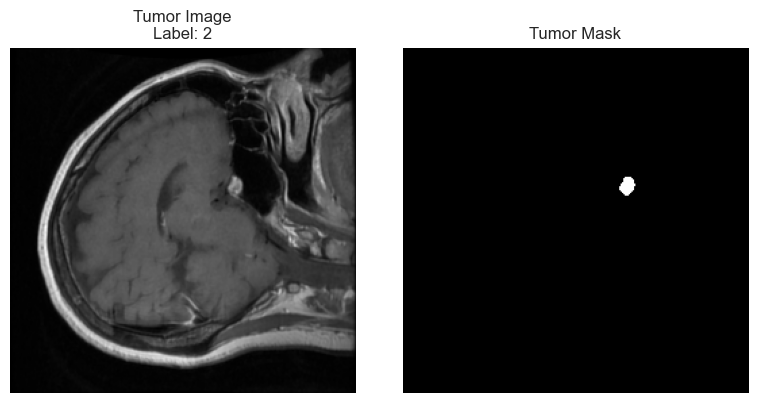

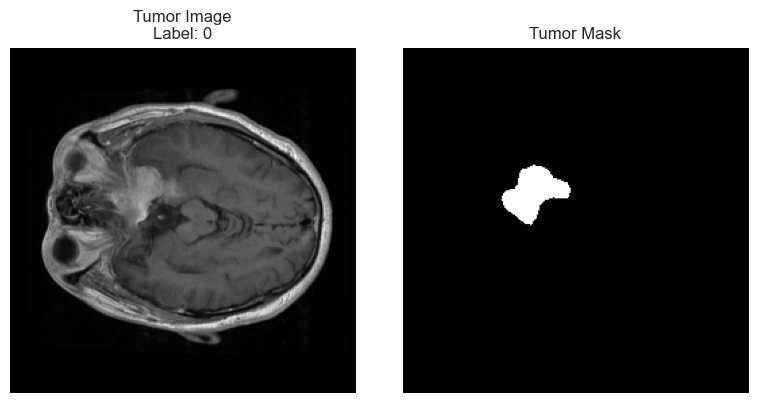

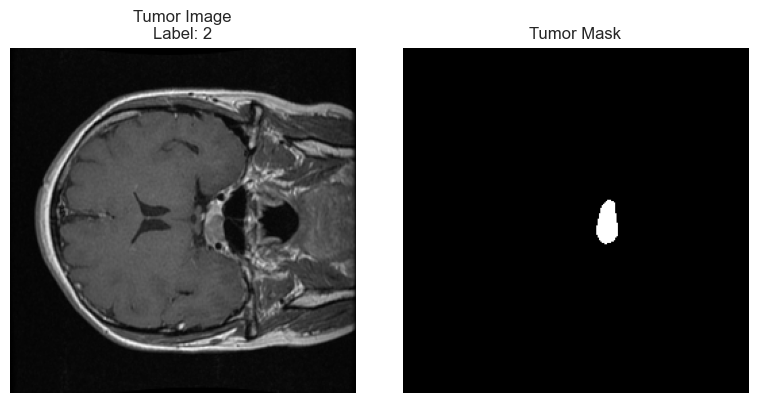

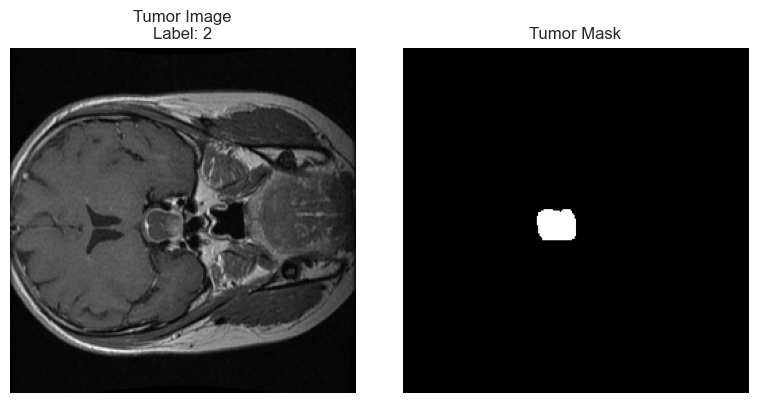

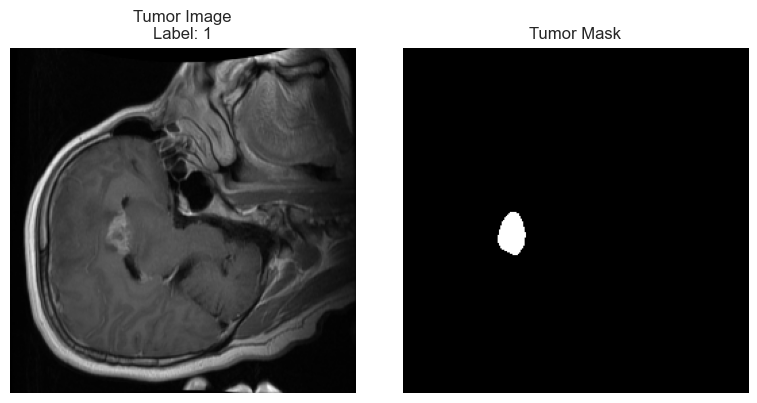

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

path = path + "/dataset/data"

# path to dataset
data_dir = path
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 0 -> meningioma  1 -> glioma  2 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocessing of MRI Scans

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

Processed X_tumor shape: (3064, 256, 256, 1)


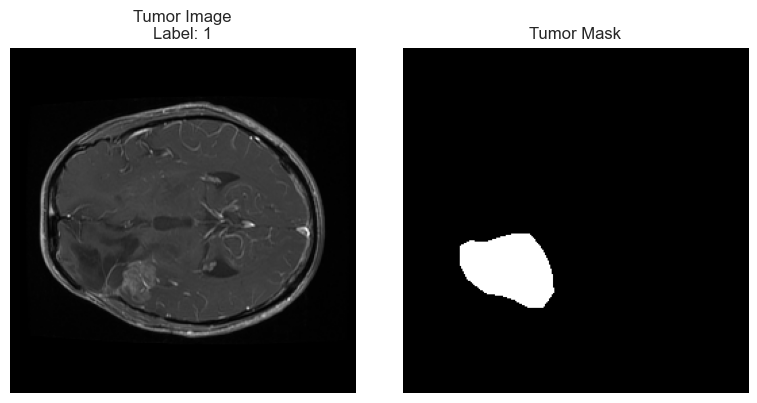

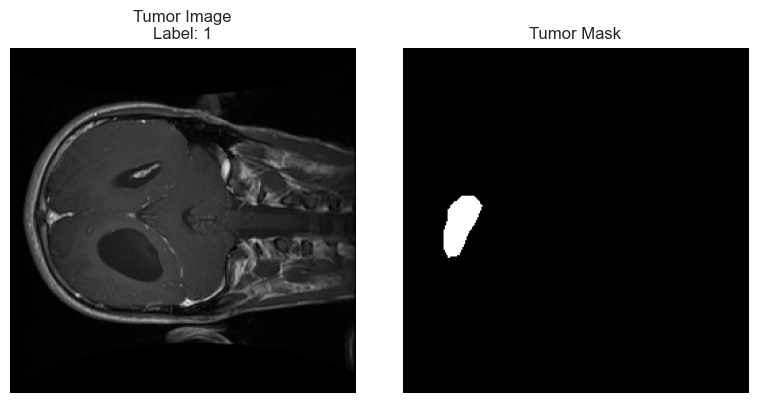

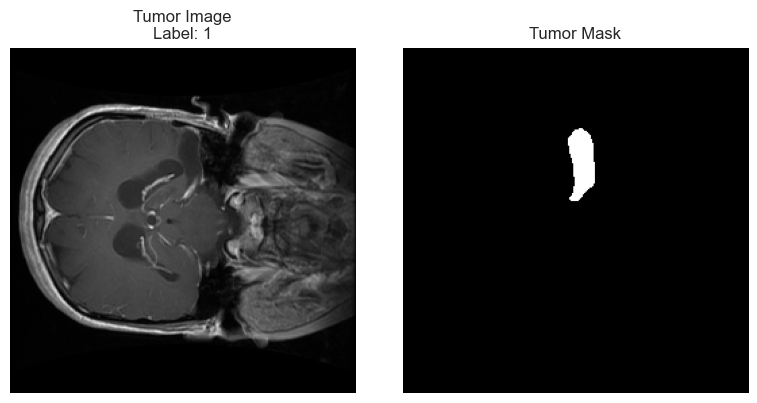

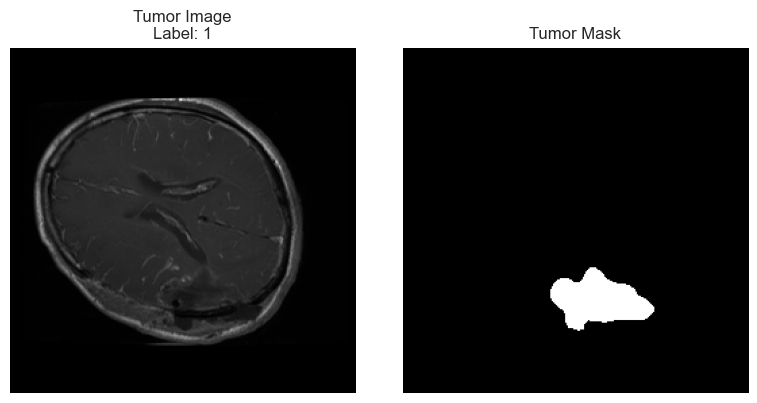

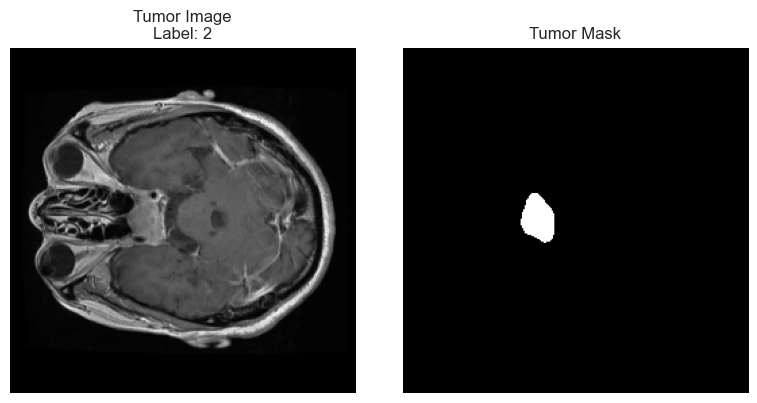

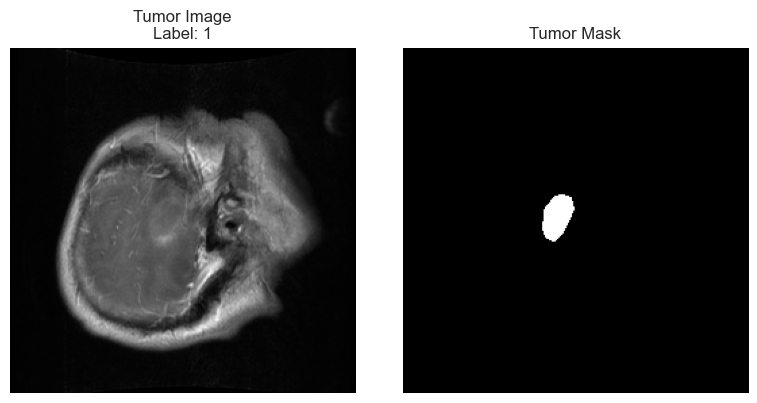

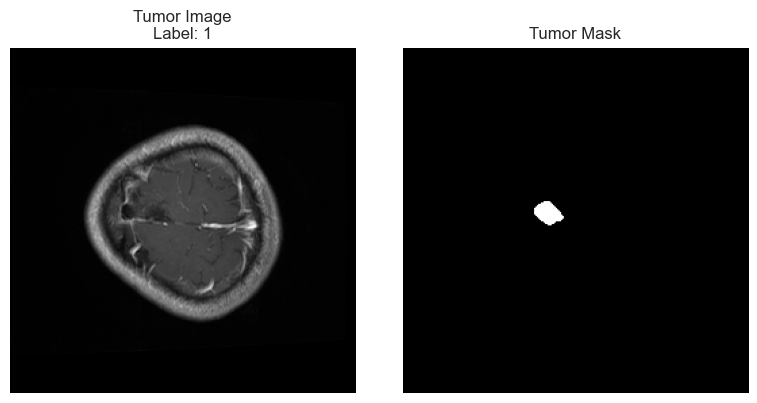

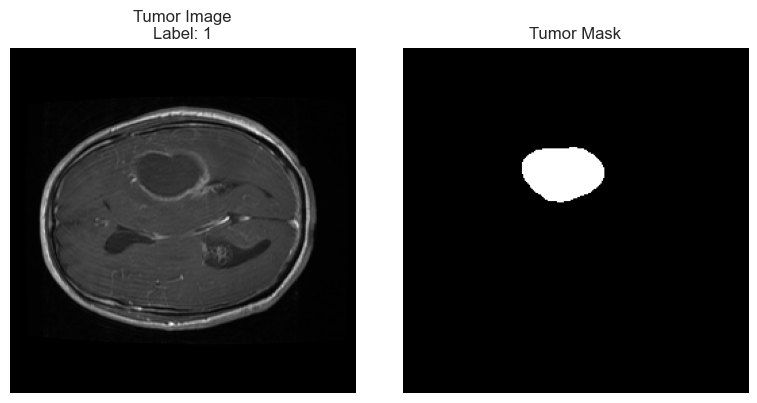

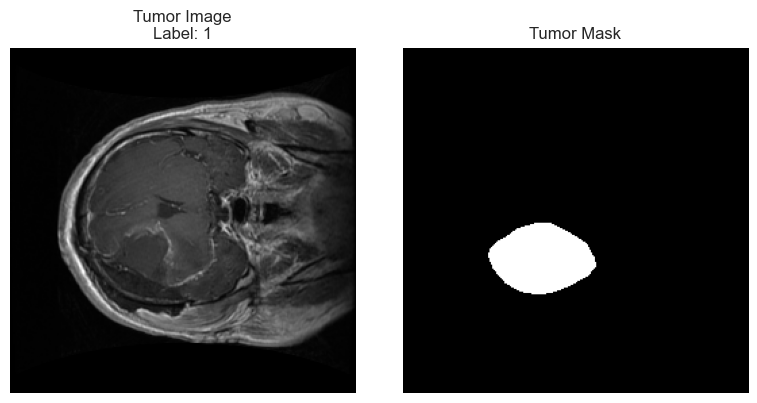

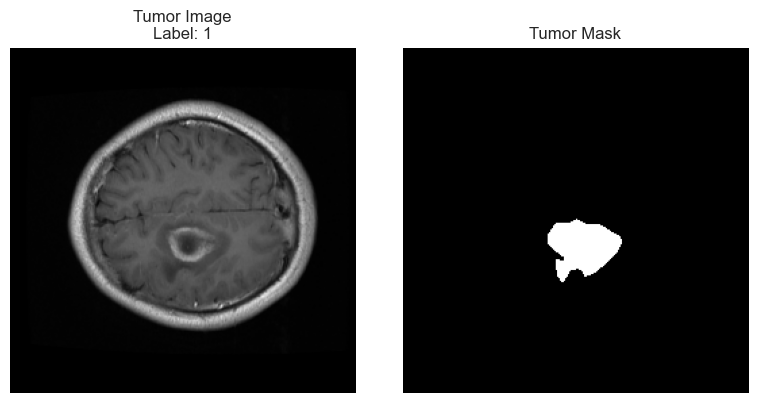

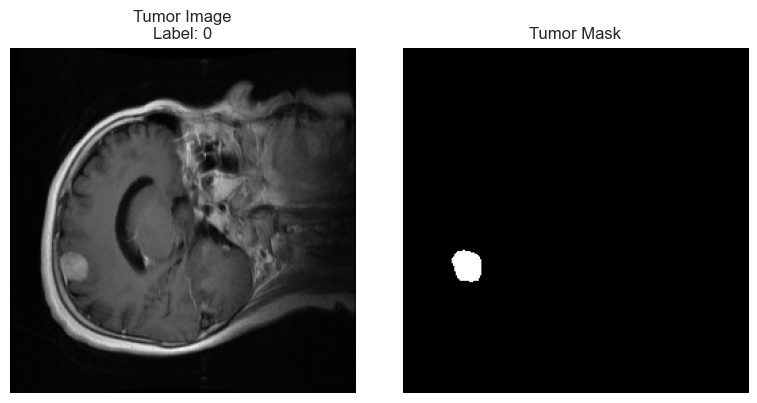

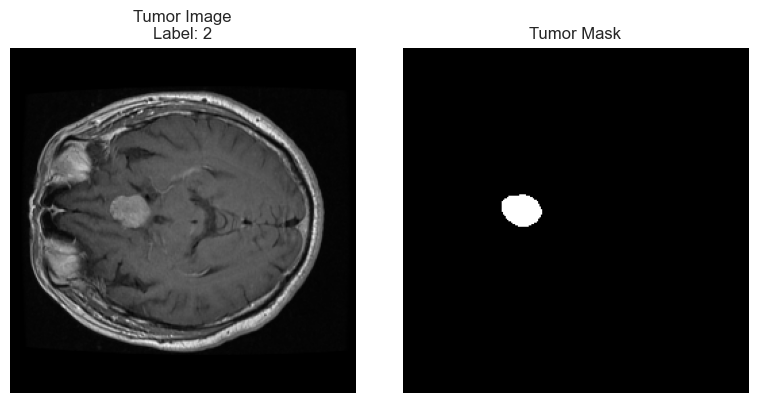

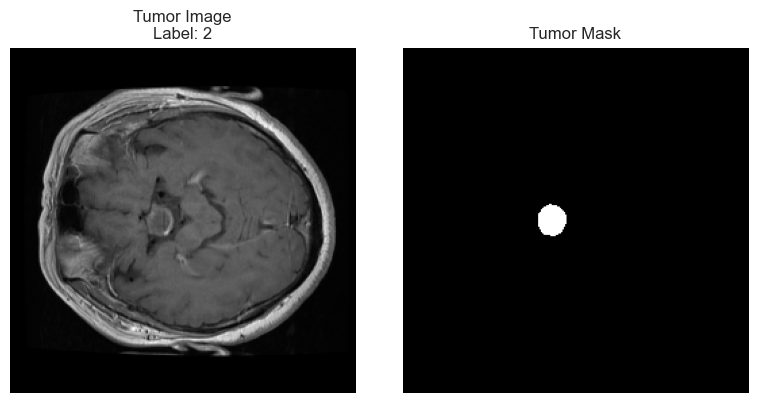

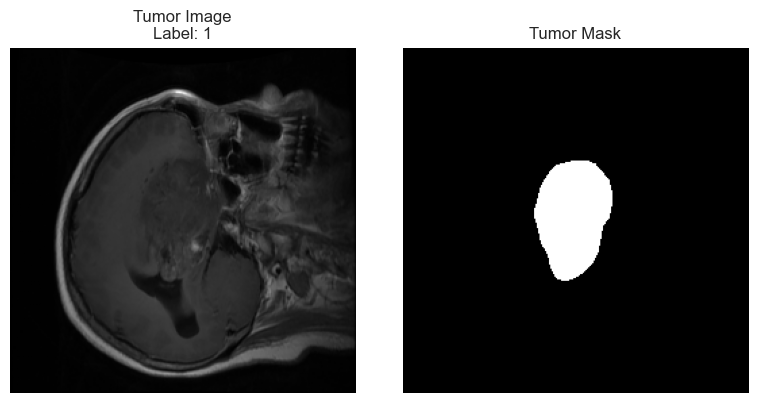

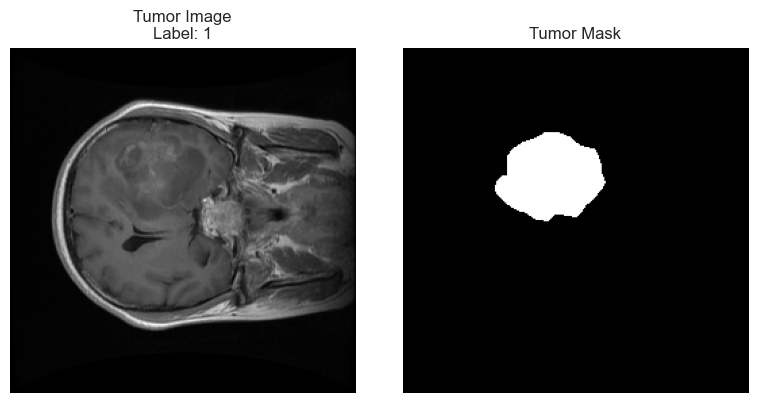

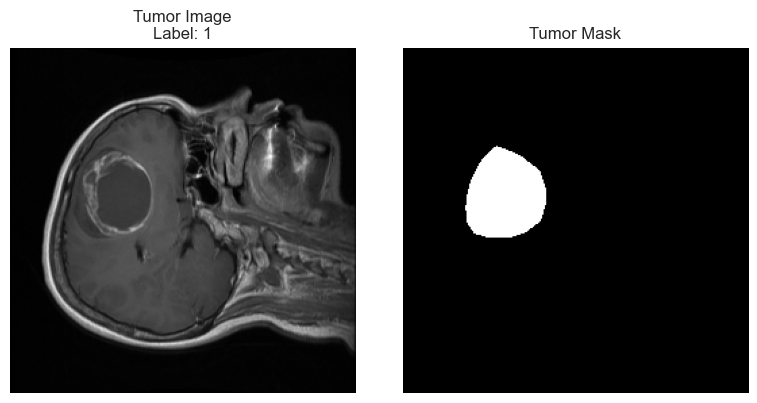

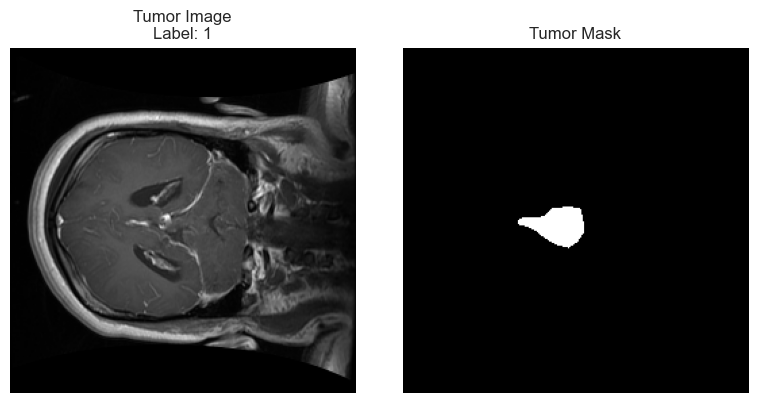

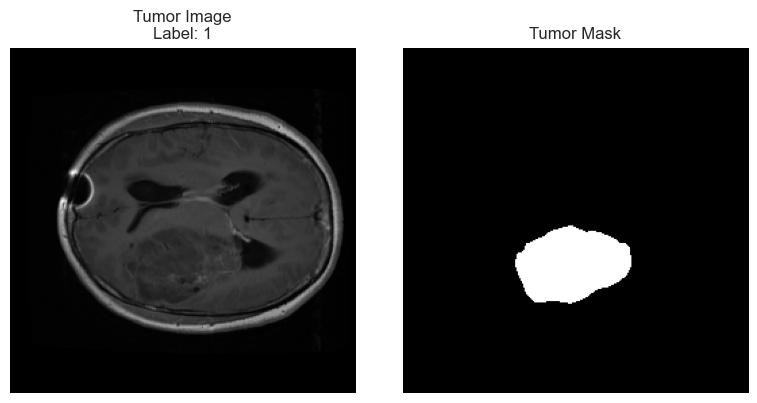

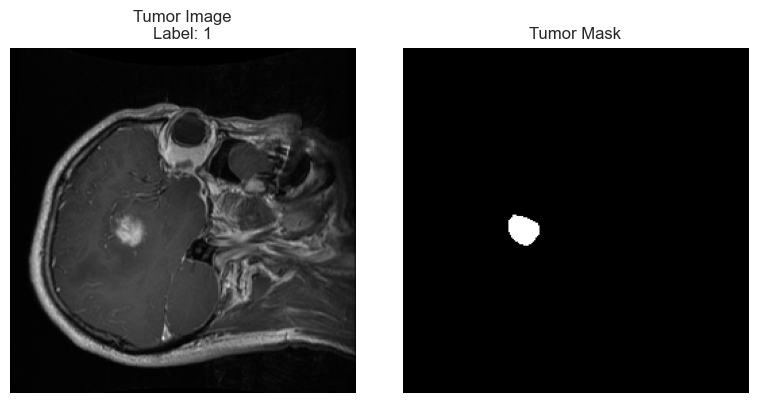

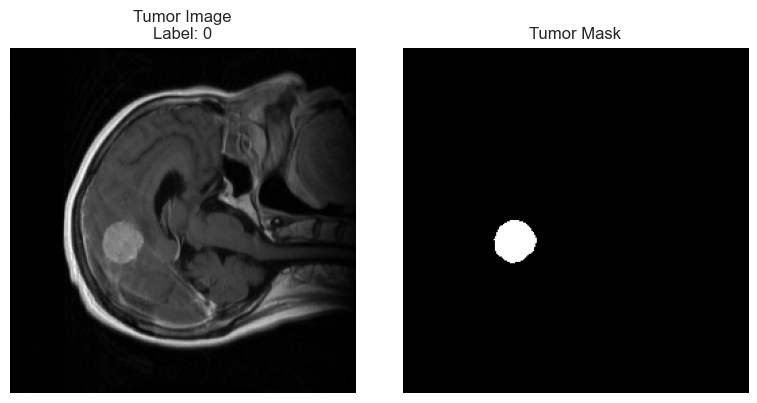

In [3]:
# for report
num_samples = 20

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor_processed[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 4. Custom DataModule via PyTorch Lightning DataModule

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module.setup()

# initialize loaders
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 5. Model D -> Simple Multi-task

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,    # weight for segmentation loss
            cls_weight: float = 0.15,    # weight for classification loss
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # load pretrained model and adjust everything similar to part2
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        self.bce_loss_fn = nn.BCEWithLogitsLoss()

        # classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )
        self.cls_loss_fn = nn.CrossEntropyLoss()

        self.seg_weight = seg_weight
        self.cls_weight = cls_weight

    def forward(self, x):
        # same explanation as in part 1 and 2
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # get features
        features = self.model.backbone(x)['out']

        seg_logits = self.model.classifier(features)
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        class_logits = self.classifier(features)

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, epsilon=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + epsilon)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        # loss calc with weights
        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        # final loss
        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


Seed set to 42


# 5.1 Train Model D

In [5]:
# initialize model, trainer, then train again for 10 epochs
model = FCNResNet50Lightning()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.fram

Train size: 2207, Val size: 245, Test size: 612



  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | FCN               | 35.3 M | train
1 | bce_loss_fn | BCEWithLogitsLoss | 0      | train
2 | classifier  | Sequential        | 1.1 M  | train
3 | cls_loss_fn | CrossEntropyLoss  | 0      | train
----------------------------------------------------------
36.4 M    Trainable params
0         Non-trainable params
36.4 M    Total params
145.430   Total estimated model params size (MB)
171       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [03:47<00:00,  0.61it/s, v_num=0, train_seg_loss=0.235, train_cls_loss=0.685, train_loss=0.303]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=0, train_seg_loss=0.247, train_cls_loss=0.407, train_loss=0.271, val_seg_loss=0.272, val_cls_loss=0.546, val_loss=0.313] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:45<00:00,  0.61it/s, v_num=0, train_seg_loss=0.203, train_cls_loss=0.188, train_loss=0.201, val_seg_loss=0.240, val_cls_loss=0.403, val_loss=0.265]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:45<00:00,  0.61it/s, v_num=0, train_seg_loss=0.162, train_cls_loss=0.0316, train_loss=0.142, val_seg_loss=0.224, val_cls_loss=0.681, val_loss=0.293] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:45<00:00,  0.61it/s, v_num=0, train_seg_loss=0.167, train_cls_loss=0.262, train_loss

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [06:35<00:00,  0.35it/s, v_num=0, train_seg_loss=0.144, train_cls_loss=0.0163, train_loss=0.125, val_seg_loss=0.162, val_cls_loss=0.260, val_loss=0.176]


# 5.2 Validation and Test losses Model D

In [6]:
# validation and test losses
model.eval()

trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 245, Test size: 612
Validation DataLoader 0: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_cls_loss          0.2598155736923218
        val_loss            0.17647376656532288
      val_seg_loss          0.16176638007164001
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.




Train size: 2207, Val size: 245, Test size: 612
Testing DataLoader 0: 100%|██████████| 39/39 [00:19<00:00,  1.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_cls_loss          0.25961679220199585
        val_loss            0.17008036375045776
      val_seg_loss          0.15427982807159424
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_seg_loss': 0.15427982807159424,
  'val_cls_loss': 0.25961679220199585,
  'val_loss': 0.17008036375045776}]

# 5.3 Dice Coefficient Model D

In [7]:
model.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, *_ in test_loader:
        imgs  = imgs.to(model.device)
        masks = masks.to(model.device)
        seg_out, _ = model(imgs)
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Part 3 dice coef at threshold of 0.65:", sum(dice_scores)/len(dice_scores))

Part 3 dice coef at threshold of 0.65: 0.7344544957845639


# 5.4 Classification Report Model D

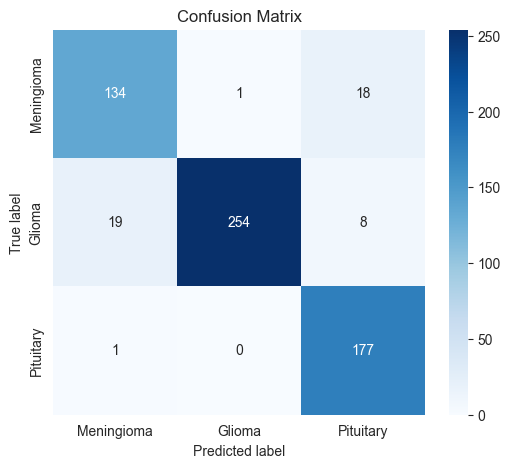

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.8701    0.8758    0.8730       153
      Glioma     0.9961    0.9039    0.9478       281
   Pituitary     0.8719    0.9944    0.9291       178

    accuracy                         0.9232       612
   macro avg     0.9127    0.9247    0.9166       612
weighted avg     0.9285    0.9232    0.9236       612



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(model.device)
        labels = labels.to(model.device)

        seg_logits, class_logits = model(images)  # get both logits

        preds = torch.argmax(class_logits, 1)  # for cls needed now

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# 5.5 Combined Output Model D

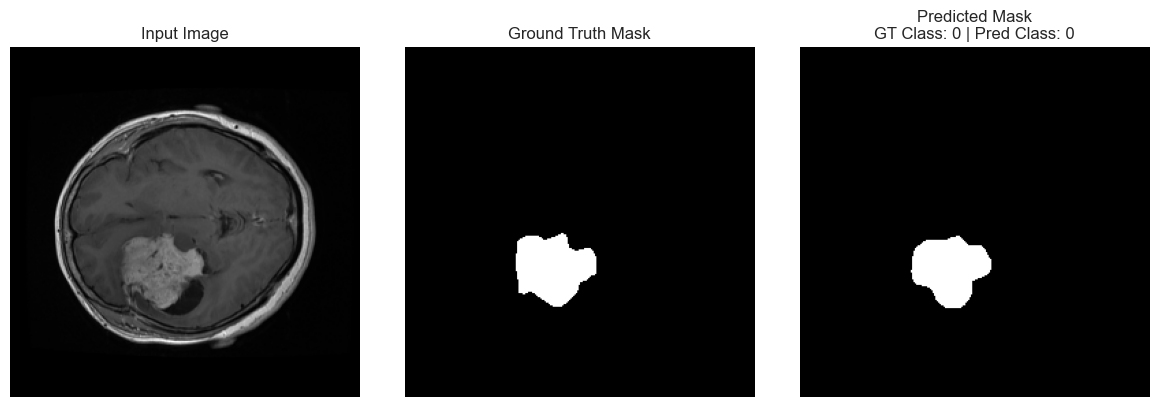

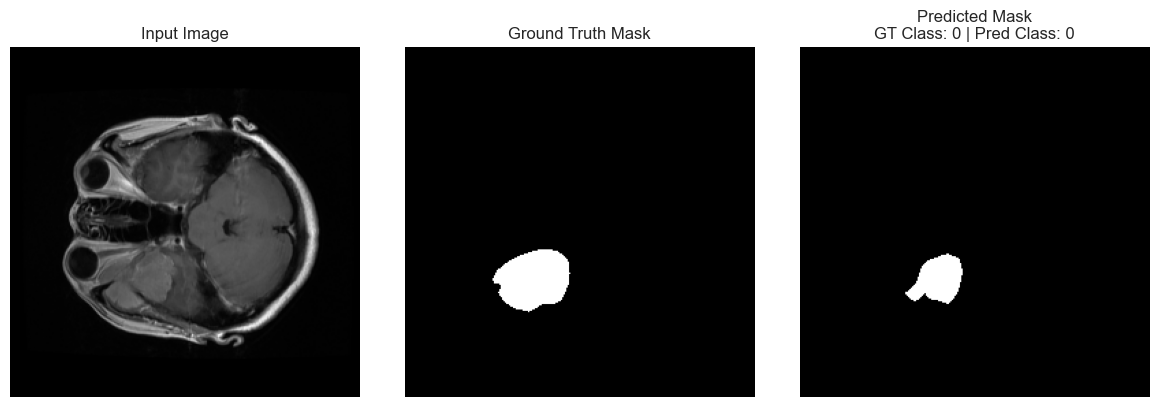

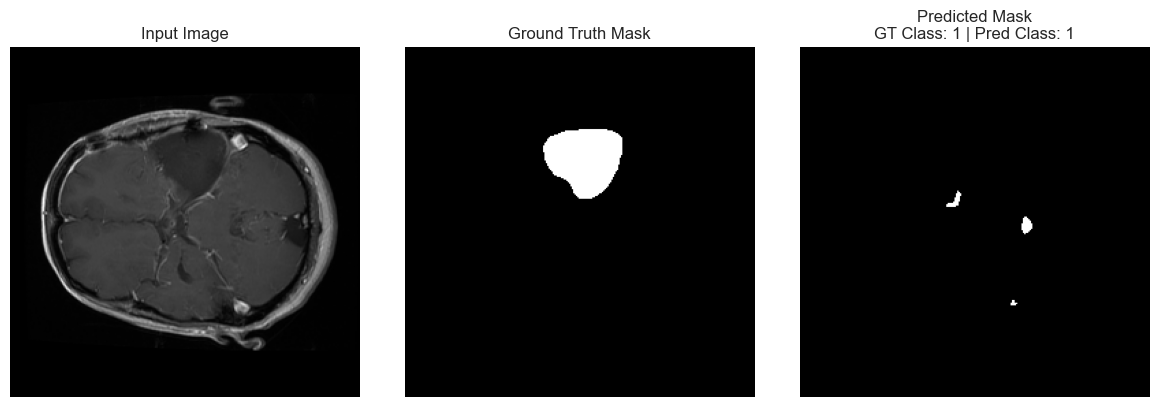

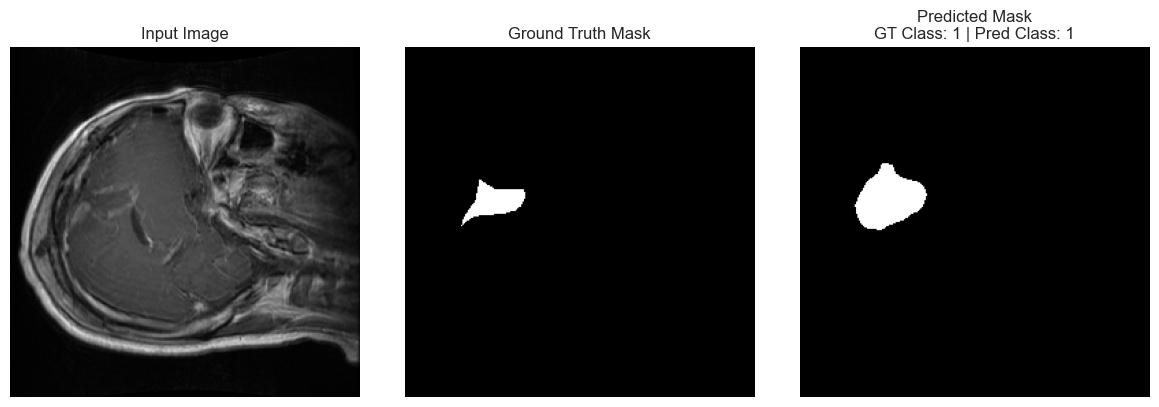

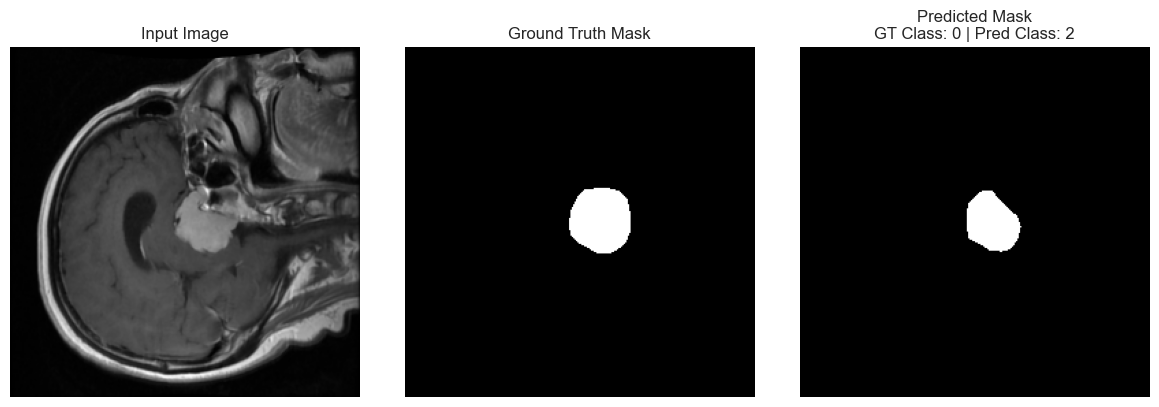

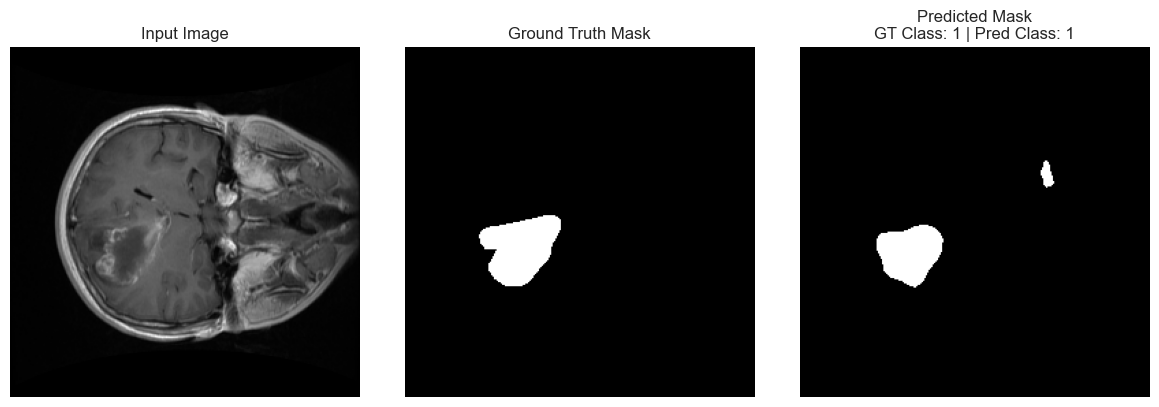

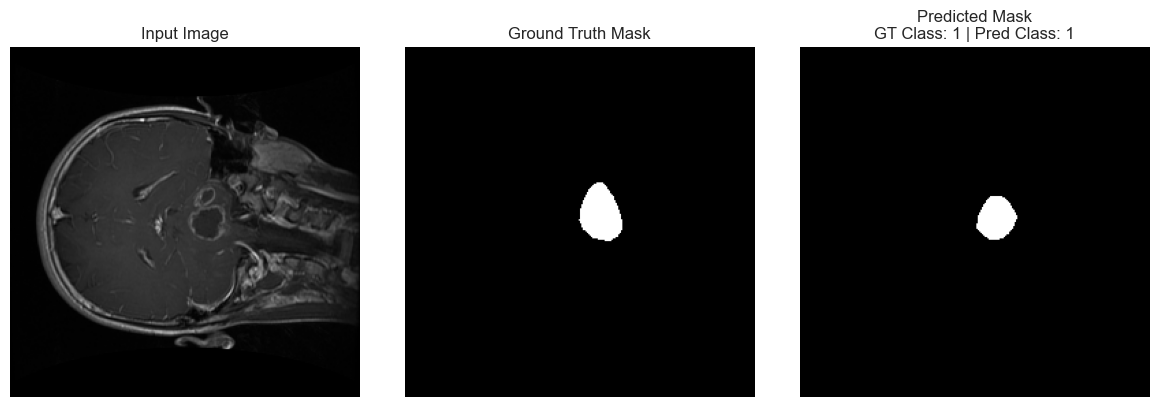

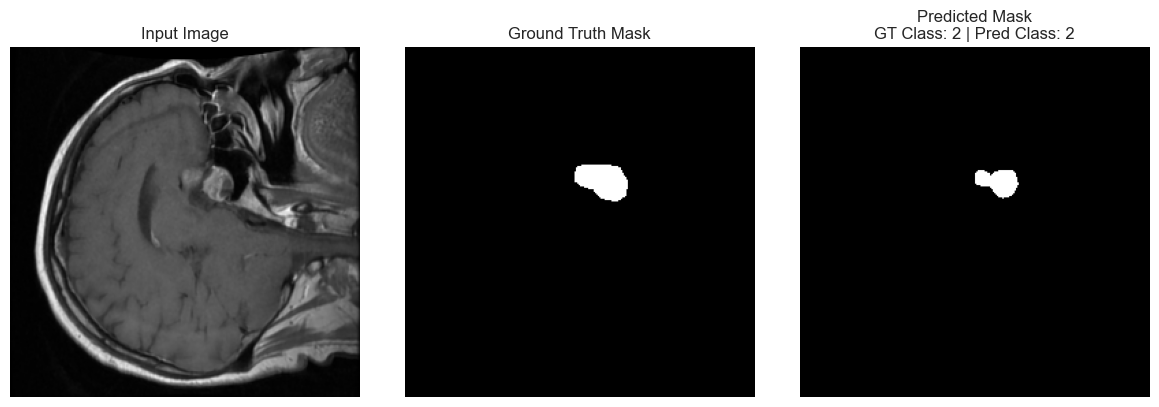

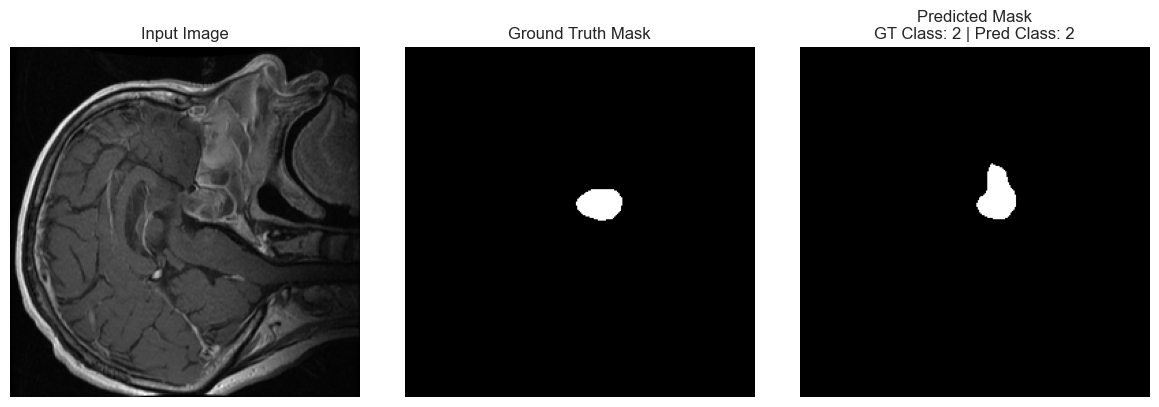

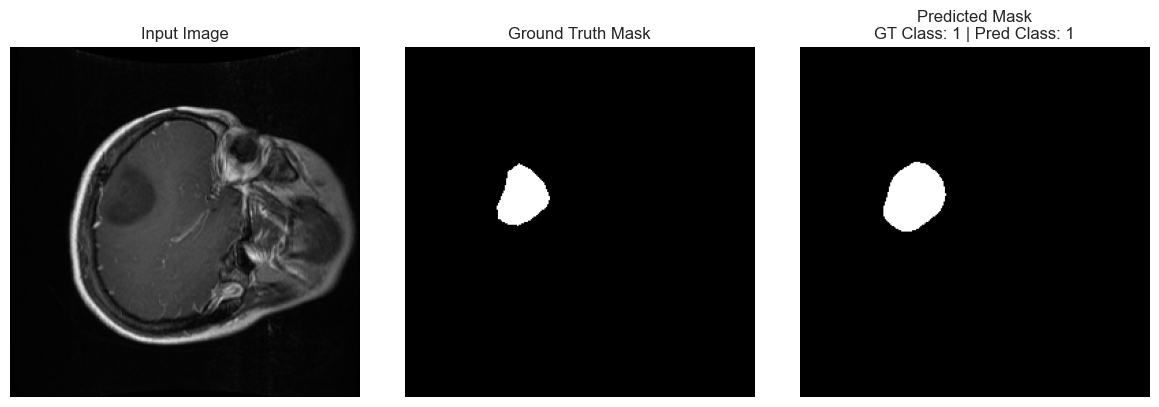

In [11]:
from tqdm import tqdm

model.eval()

all_images = []
all_masks = []
all_seg_preds = []
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for images, masks, labels in tqdm(test_loader, desc="Collecting test examples"):
        seg_out, class_out = model(images)

        seg_out = F.interpolate(                      # same upsampling
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        pred_labels = torch.argmax(class_out, dim=1)

        all_images.append(images)
        all_masks.append(masks)
        all_seg_preds.append(seg_out)
        all_true_labels.append(labels)
        all_pred_labels.append(pred_labels)

all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_seg_preds = torch.cat(all_seg_preds, dim=0)
all_true_labels = torch.cat(all_true_labels, dim=0)
all_pred_labels = torch.cat(all_pred_labels, dim=0)


num_samples = 10
indices = torch.randperm(all_images.shape[0])[:num_samples]

for idx in indices:
    image = all_images[idx].cpu().numpy().squeeze()
    mask = all_masks[idx].cpu().numpy().squeeze()
    seg_pred = all_seg_preds[idx].cpu().numpy().squeeze()

    seg_pred_bin = (seg_pred > 0.5).astype(float)

    true_label = all_true_labels[idx].item()
    pred_label = all_pred_labels[idx].item()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg_pred_bin, cmap='gray')
    plt.title(f"Predicted mask\nGround truth class: {true_label} | Predicted class: {pred_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Save model

In [9]:
trainer.save_checkpoint("checkpoints/Model_D_Simple_Multi_Task.ckpt")

# 6. Model E -> Classification informed Segmentation
## Here, classification embeddings are addded to the segmentation part.

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Classification Logits and Segmentation Decoder Modification
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) projection for classifier logits → 2048 channels
        self.cls_proj = nn.Linear(num_cls_classes, 2048)

        # 3) classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # classification
        class_logits = self.classifier(features)  # [B,3]

        # project & add back to features
        cls_embed = self.cls_proj(class_logits)        # [B,2048]
        cls_embed = cls_embed.view(-1, 2048, 1, 1)     # [B,2048,1,1]
        features = features + cls_embed                # broadcast add

        # segmentation decoder
        seg_logits = self.model.classifier(features)    # [B,1,H/8,W/8]
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],                          # up to original H,W
            mode='bilinear',
            align_corners=False
        )

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 6.1 Train Model E

In [5]:
new_model = FCNResNet50Lightning()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(new_model, datamodule=data_module)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.fram

Train size: 2207, Val size: 245, Test size: 612
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [03:47<00:00,  0.61it/s, v_num=2, train_seg_loss=0.286, train_cls_loss=0.181, train_loss=0.271] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:54<00:00,  0.59it/s, v_num=2, train_seg_loss=0.212, train_cls_loss=0.228, train_loss=0.214, val_seg_loss=0.286, val_cls_loss=0.557, val_loss=0.327] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:56<00:00,  0.58it/s, v_num=2, train_seg_loss=0.151, train_cls_loss=0.357, train_loss=0.182, val_seg_loss=0.242, val_cls_loss=0.700, val_loss=0.311] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:58<00:00,  0.58it/s, v_num=2, train_seg_loss=0.101, train_cls_loss=0.102, train_loss=0.101, val_seg_loss=0.284, val_cls_loss=1.360, val_loss=0.446] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:59<00:00,  0.58it/s, v_num=2, train_seg_loss=0.198, train_cls_loss=0.144, train_loss=0

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [03:53<00:00,  0.59it/s, v_num=2, train_seg_loss=0.0957, train_cls_loss=0.00917, train_loss=0.0827, val_seg_loss=0.159, val_cls_loss=0.117, val_loss=0.152]


# 6.2 Dice coefficient Model E

In [6]:
new_model.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, labels in test_loader:
        imgs  = imgs.to(new_model.device)
        masks = masks.to(new_model.device)
        labels = labels.to(new_model.device)
        seg_out, _ = new_model(imgs)
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Classification embeddings into segmentation version dice coef at threshold of 0.65:", sum(dice_scores)/len(dice_scores))
# improvement of 2.34% from baseline segmentation (0.7311), therefore classification helped segmentation

Classification embeddings into segmentation version dice coef at threshold of 0.65: 0.7482169163532746


# 6.3 Classification Report Model E

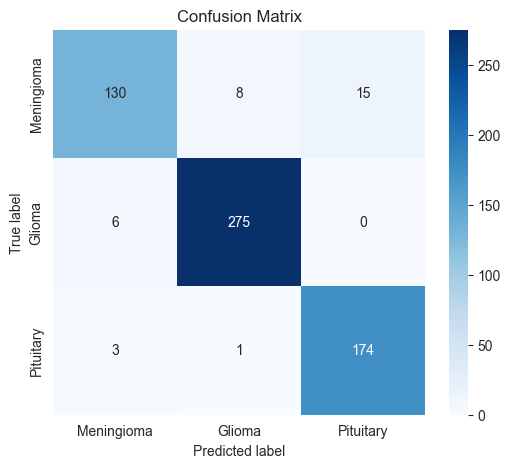

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.9353    0.8497    0.8904       153
      Glioma     0.9683    0.9786    0.9735       281
   Pituitary     0.9206    0.9775    0.9482       178

    accuracy                         0.9461       612
   macro avg     0.9414    0.9353    0.9374       612
weighted avg     0.9462    0.9461    0.9454       612



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

new_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(new_model.device)
        masks = masks.to(new_model.device)
        labels = labels.to(new_model.device)

        seg_logits, class_logits = new_model(images)  # get both logits

        preds = torch.argmax(class_logits, 1)  # for cls needed now

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# 6.4 Combined output Model E

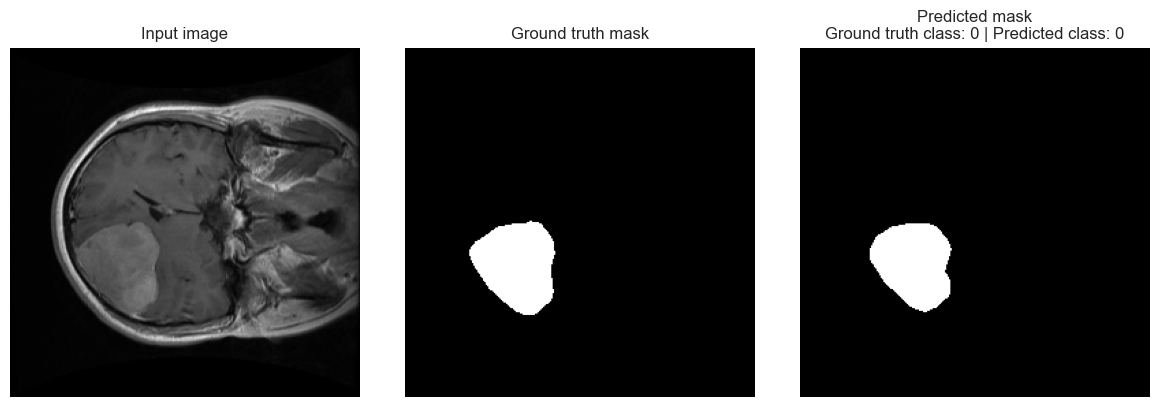

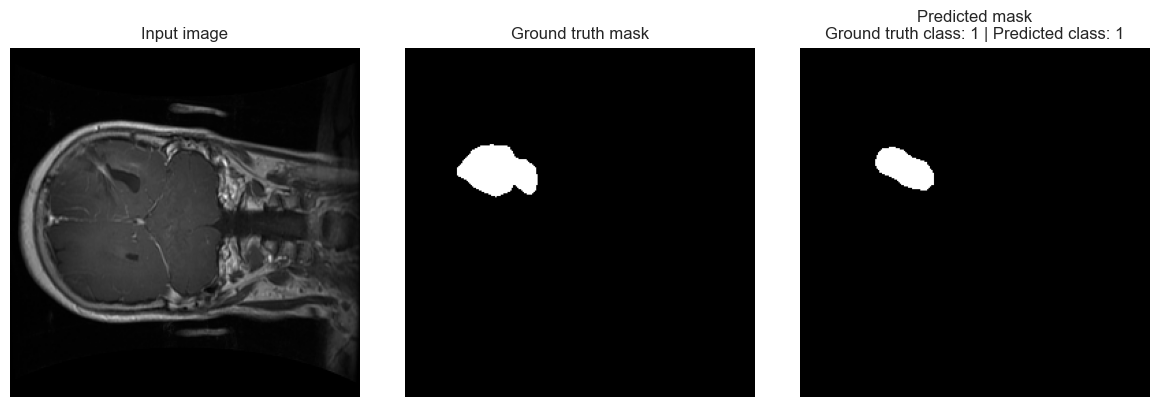

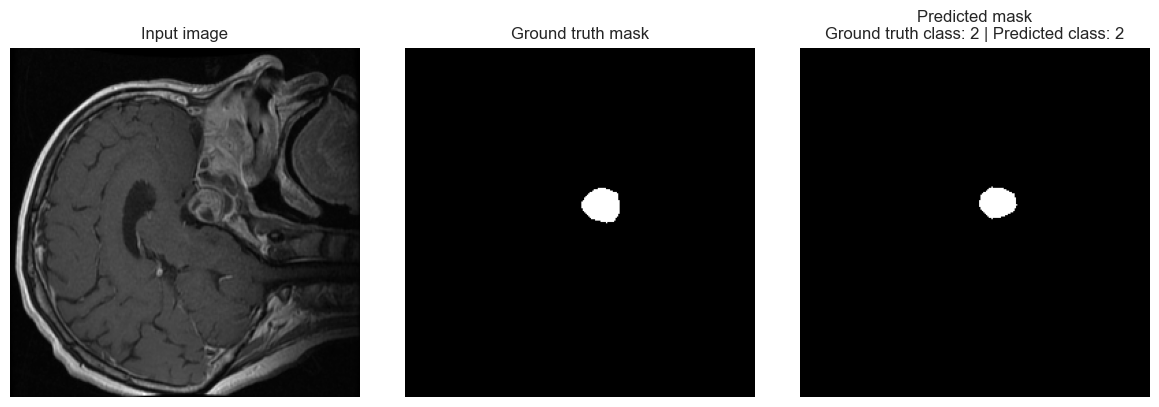

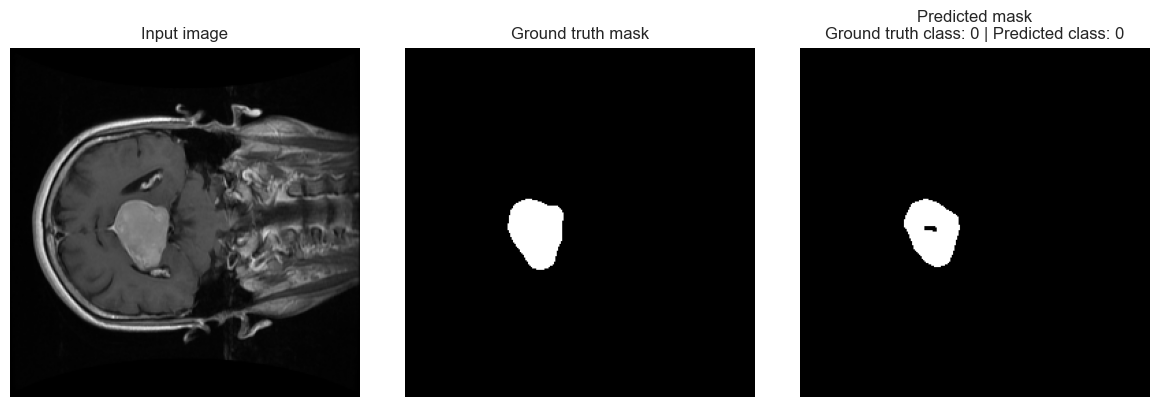

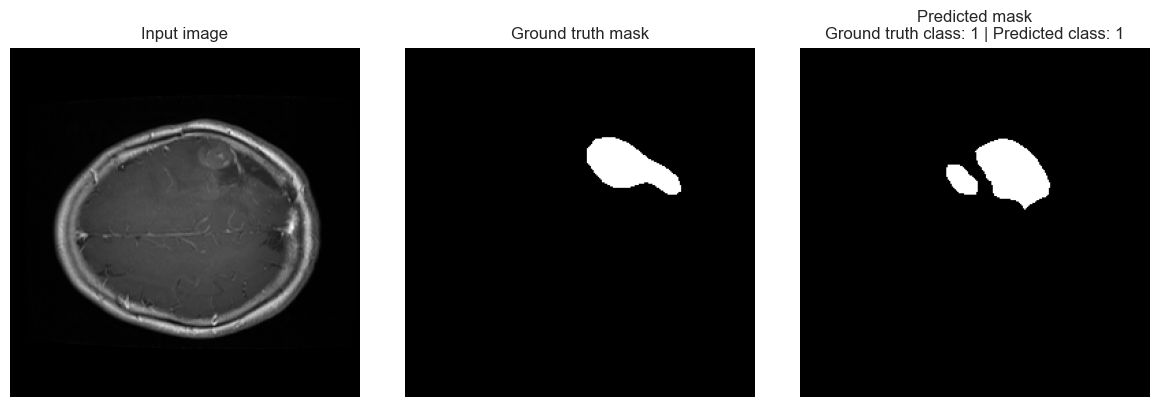

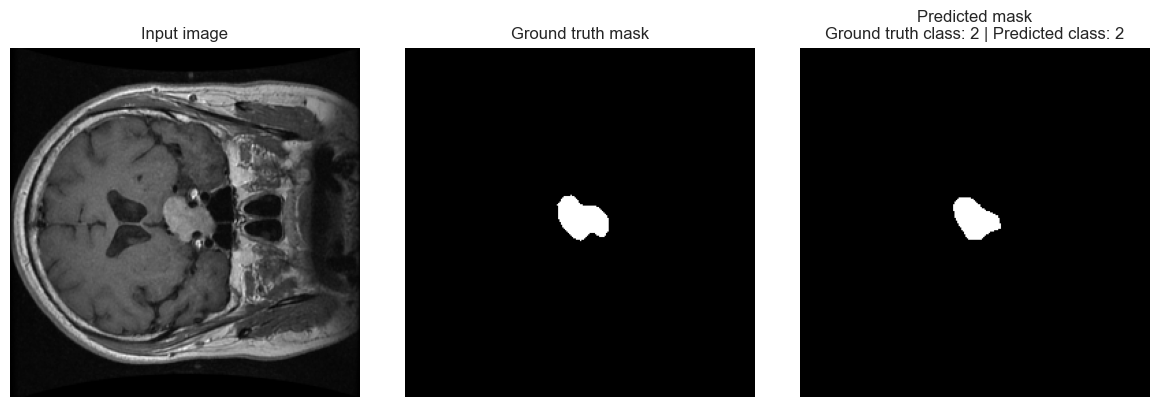

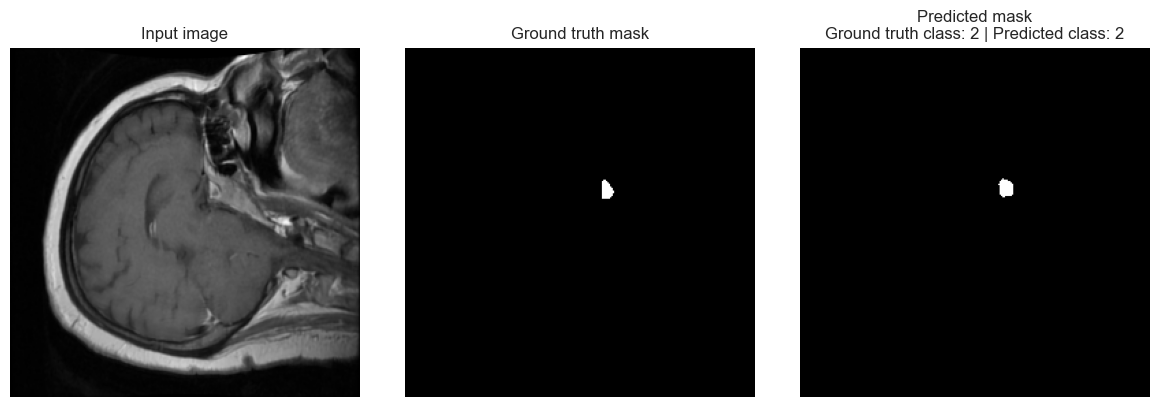

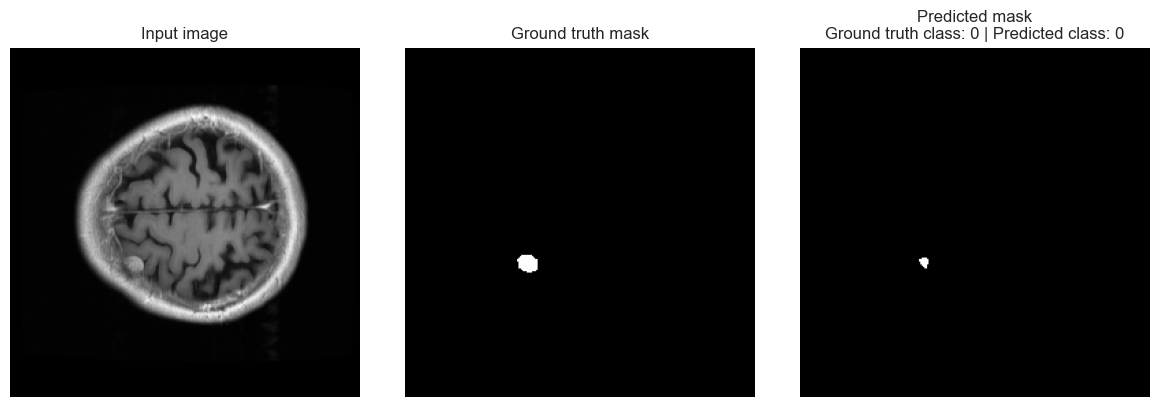

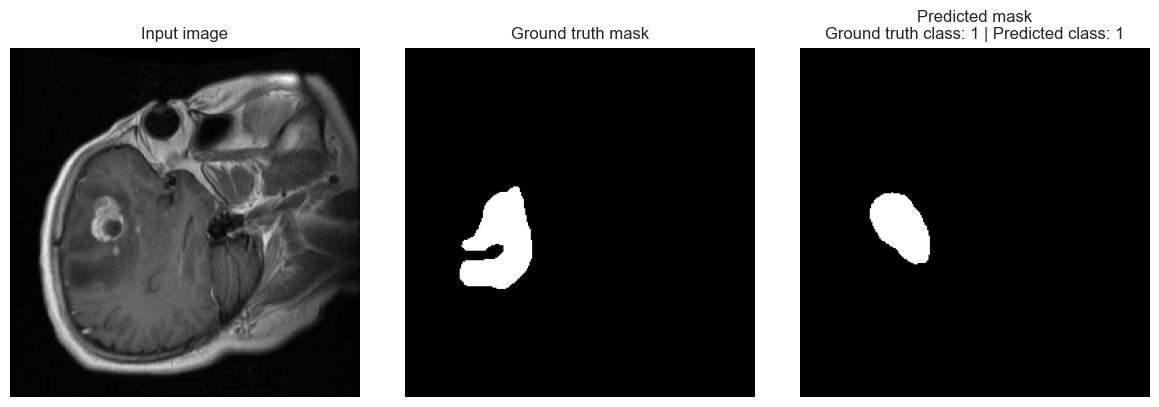

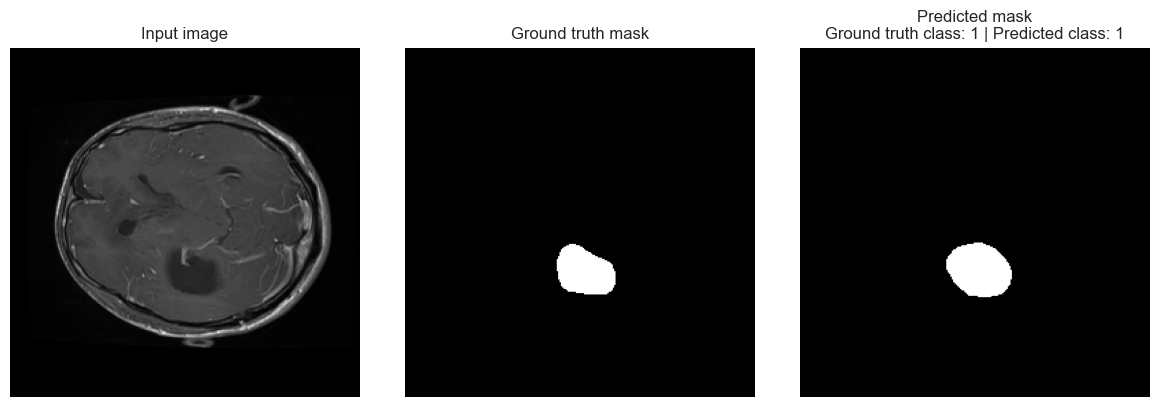

In [9]:
from tqdm import tqdm

new_model.eval()

all_images = []
all_masks = []
all_seg_preds = []
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for images, masks, labels in tqdm(test_loader, desc="Collecting test examples"):
        seg_out, class_out = new_model(images)

        seg_out = F.interpolate(                      # same upsampling
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        pred_labels = torch.argmax(class_out, dim=1)

        all_images.append(images)
        all_masks.append(masks)
        all_seg_preds.append(seg_out)
        all_true_labels.append(labels)
        all_pred_labels.append(pred_labels)


all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_seg_preds = torch.cat(all_seg_preds, dim=0)
all_true_labels = torch.cat(all_true_labels, dim=0)
all_pred_labels = torch.cat(all_pred_labels, dim=0)


num_samples = 10
indices = torch.randperm(all_images.shape[0])[:num_samples]

for idx in indices:
    image = all_images[idx].cpu().numpy().squeeze()
    mask = all_masks[idx].cpu().numpy().squeeze()
    seg_pred = all_seg_preds[idx].cpu().numpy().squeeze()

    seg_pred_bin = (seg_pred > 0.5).astype(float)

    true_label = all_true_labels[idx].item()
    pred_label = all_pred_labels[idx].item()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg_pred_bin, cmap='gray')
    plt.title(f"Predicted mask\nGround truth class: {true_label} | Predicted class: {pred_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Save model

In [8]:
trainer.save_checkpoint("checkpoints/Model_E_Classification_Informed_Segmentation.ckpt")

# 7. Model F -> Segmentation informed Classification
## Other way around, use segmentation features in classification.

In [5]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Segmentation Logits
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) Load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) Create a segmentation feature extractor
        # This will extract features from segmentation decoder
        self.seg_feature_extractor = nn.Sequential(
            nn.Conv2d(num_seg_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # 3) Classification head that integrates backbone features and segmentation features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 + 64, 512),  # 2048 from backbone + 64 from seg features
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # Losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # Ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Get encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # Run segmentation decoder
        seg_logits = self.model.classifier(features)  # [B,1,H/8,W/8]

        # Extract features from segmentation logits
        seg_features = self.seg_feature_extractor(seg_logits)  # [B,64,H/16,W/16]

        # Global average pooling on both feature sets
        global_features = F.adaptive_avg_pool2d(features, 1)  # [B,2048,1,1]
        global_seg_features = F.adaptive_avg_pool2d(seg_features, 1)  # [B,64,1,1]

        # Concatenate both feature types
        combined_features = torch.cat([
            global_features.flatten(1),
            global_seg_features.flatten(1)
        ], dim=1)  # [B,2048+64]

        # Run classifier on combined features
        class_logits = self.classifier[2:](combined_features)  # Skip pooling & flatten

        # Upsample segmentation to original size
        seg_logits_full = F.interpolate(
            seg_logits,
            size=x.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        return seg_logits_full, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 7.1 Train Model F

In [11]:
new_model_2 = FCNResNet50Lightning()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(new_model_2, datamodule=data_module)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Train size: 2207, Val size: 245, Test size: 612



  | Name                  | Type              | Params | Mode 
--------------------------------------------------------------------
0 | model                 | FCN               | 35.3 M | train
1 | seg_feature_extractor | Sequential        | 768    | train
2 | classifier            | Sequential        | 1.1 M  | train
3 | bce_loss_fn           | BCEWithLogitsLoss | 0      | train
4 | cls_loss_fn           | CrossEntropyLoss  | 0      | train
--------------------------------------------------------------------
36.4 M    Trainable params
0         Non-trainable params
36.4 M    Total params
145.564   Total estimated model params size (MB)
176       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [03:53<00:00,  0.59it/s, v_num=3, train_seg_loss=0.195, train_cls_loss=0.460, train_loss=0.235] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:52<00:00,  0.59it/s, v_num=3, train_seg_loss=0.151, train_cls_loss=0.483, train_loss=0.201, val_seg_loss=0.287, val_cls_loss=0.375, val_loss=0.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:46<00:00,  0.61it/s, v_num=3, train_seg_loss=0.184, train_cls_loss=0.163, train_loss=0.180, val_seg_loss=0.252, val_cls_loss=0.360, val_loss=0.268] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=3, train_seg_loss=0.133, train_cls_loss=0.484, train_loss=0.186, val_seg_loss=0.199, val_cls_loss=0.264, val_loss=0.209]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=3, train_seg_loss=0.084, train_cls_loss=0.0174, train_loss

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [03:56<00:00,  0.58it/s, v_num=3, train_seg_loss=0.132, train_cls_loss=0.0021, train_loss=0.113, val_seg_loss=0.155, val_cls_loss=0.158, val_loss=0.156]


# 7.2 Dice coefficient Model F

In [12]:
new_model_2.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, labels in test_loader:
        imgs  = imgs.to(new_model_2.device)
        masks = masks.to(new_model_2.device)
        labels = labels.to(new_model_2.device)
        seg_out, _ = new_model_2(imgs)
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Segmentation into classification version dice coef at threshold of 0.65:", sum(dice_scores)/len(dice_scores))

Segmentation into classification version dice coef at threshold of 0.65: 0.7517755321967297


# 7.3 Classificaton Report Model F

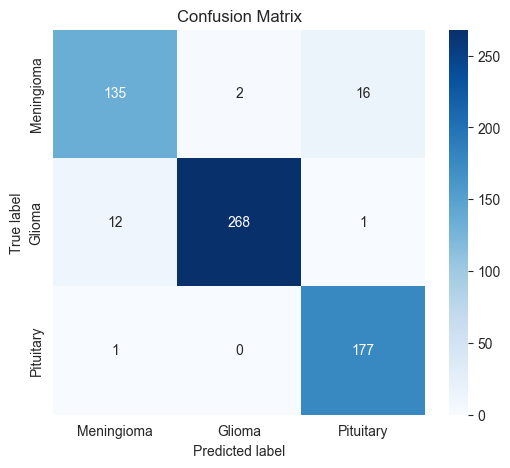

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.9122    0.8824    0.8970       153
      Glioma     0.9926    0.9537    0.9728       281
   Pituitary     0.9124    0.9944    0.9516       178

    accuracy                         0.9477       612
   macro avg     0.9390    0.9435    0.9405       612
weighted avg     0.9492    0.9477    0.9477       612



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

new_model_2.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(new_model_2.device)
        masks = masks.to(new_model_2.device)
        labels = labels.to(new_model_2.device)

        seg_logits, class_logits = new_model_2(images)  # get both logits

        preds = torch.argmax(class_logits, 1)  # for cls needed now

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))
# improvement of 4.69% from baseline classification (0.9052), therefore segmentation improved classification

# Save model

In [14]:
trainer.save_checkpoint("checkpoints/Model_F_Segmentation_Informed_Classification.ckpt")

# 7.4 Combined output Model F

In [7]:
model_seg_into_cls = FCNResNet50Lightning.load_from_checkpoint('checkpoints/Model_F_Segmentation_Informed_Classification.ckpt')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


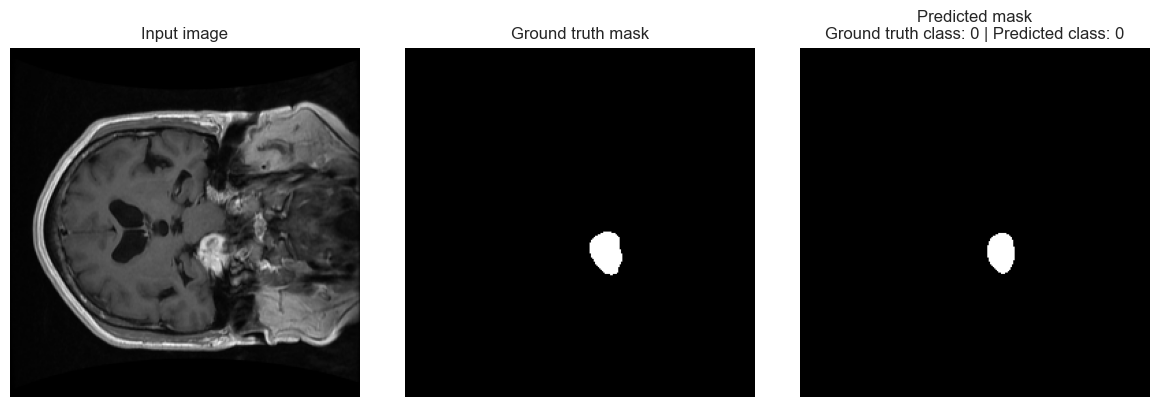

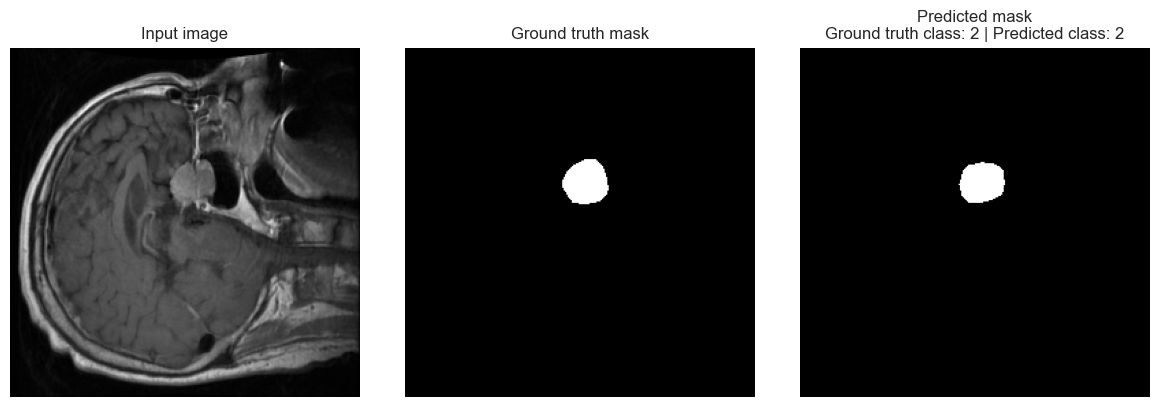

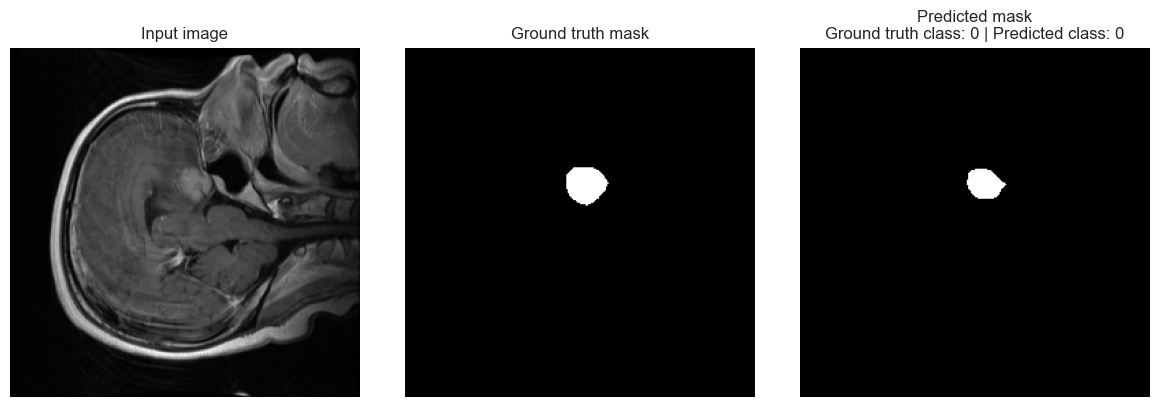

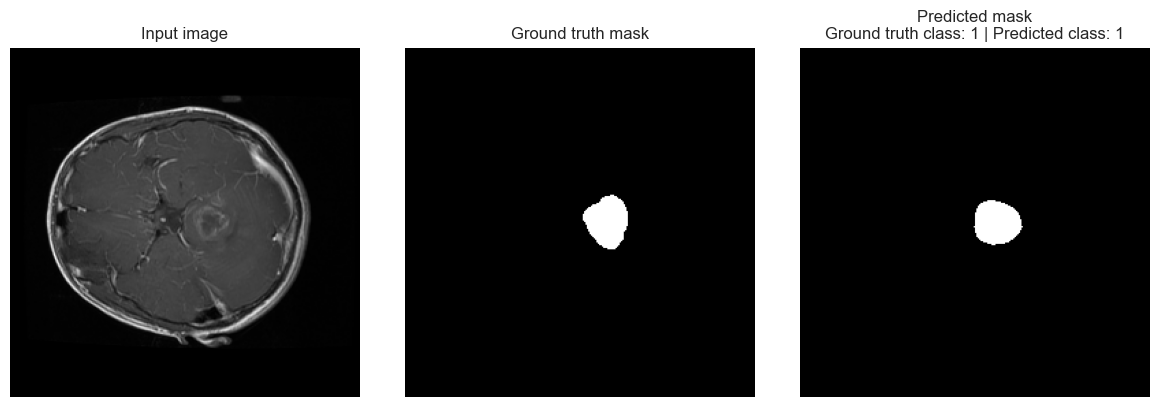

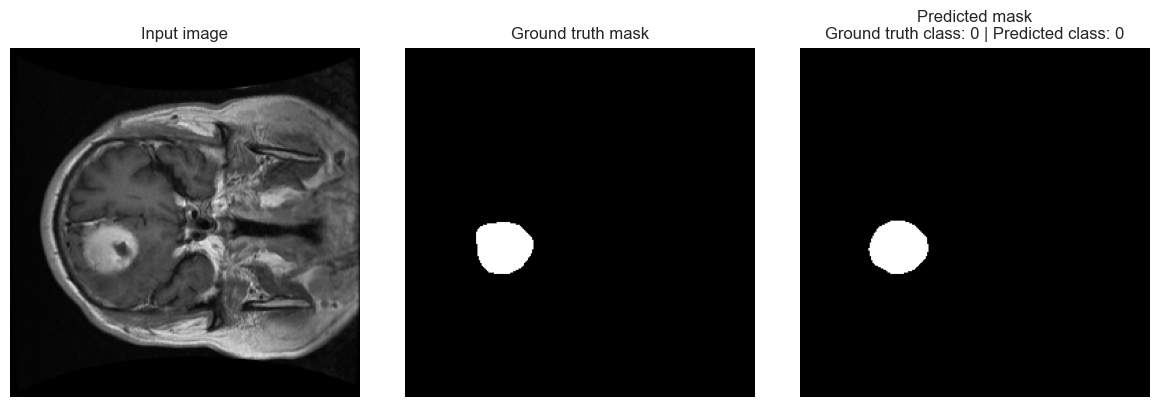

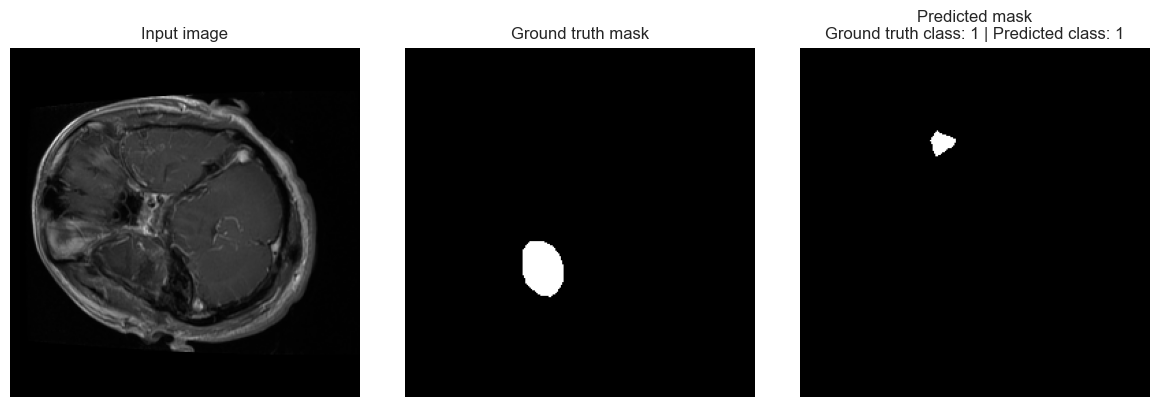

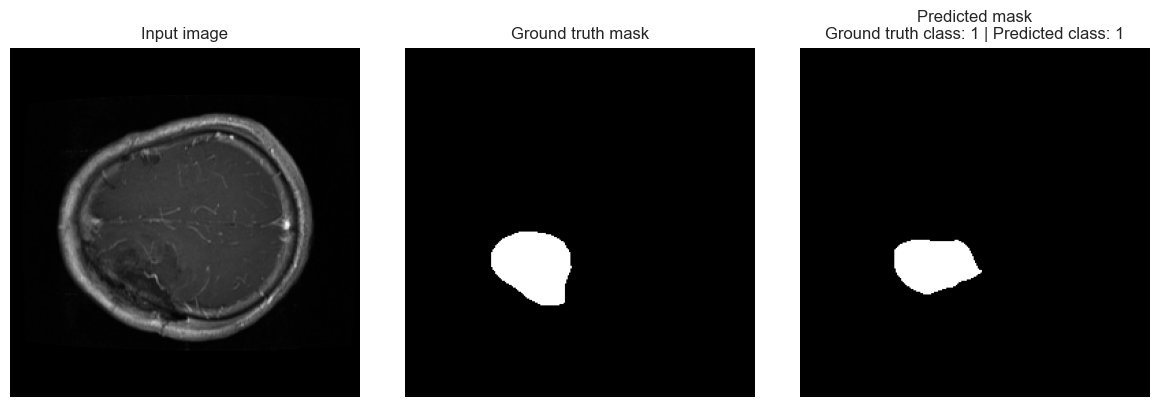

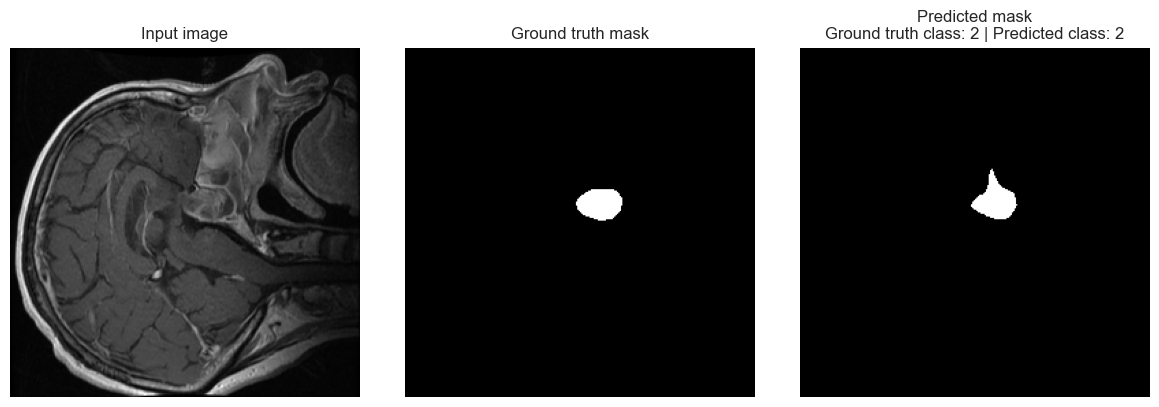

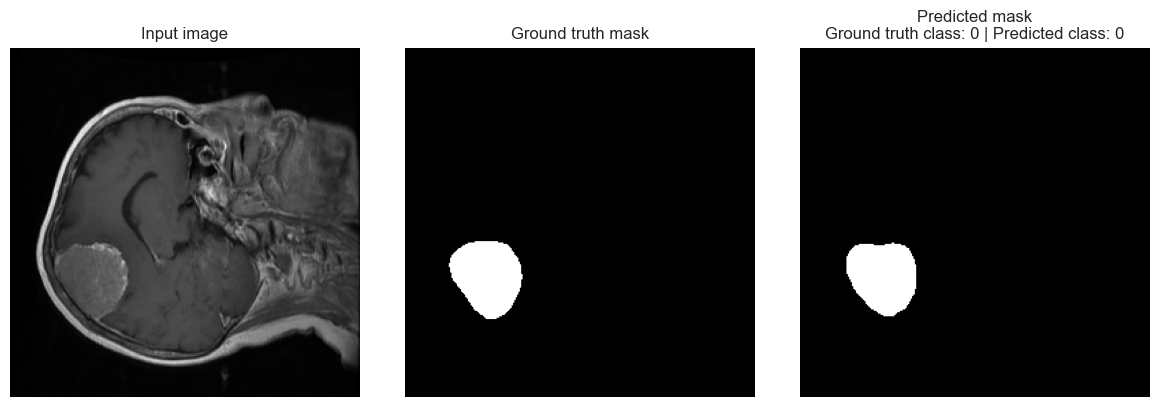

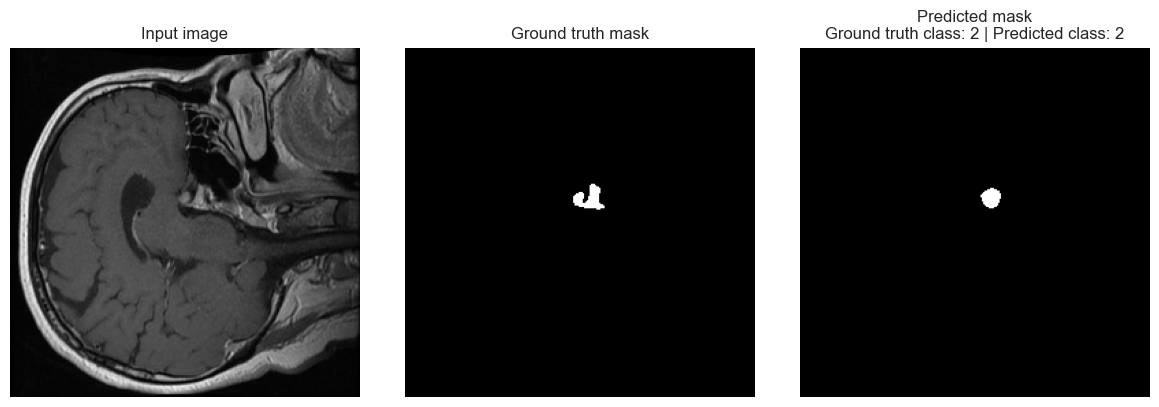

In [8]:
from tqdm import tqdm

model_seg_into_cls.eval()

all_images = []
all_masks = []
all_seg_preds = []
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for images, masks, labels in tqdm(test_loader, desc="Collecting test examples"):
        seg_out, class_out = model_seg_into_cls(images)

        seg_out = F.interpolate(                      # same upsampling
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        pred_labels = torch.argmax(class_out, dim=1)

        all_images.append(images)
        all_masks.append(masks)
        all_seg_preds.append(seg_out)
        all_true_labels.append(labels)
        all_pred_labels.append(pred_labels)


all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_seg_preds = torch.cat(all_seg_preds, dim=0)
all_true_labels = torch.cat(all_true_labels, dim=0)
all_pred_labels = torch.cat(all_pred_labels, dim=0)


num_samples = 10
indices = torch.randperm(all_images.shape[0])[:num_samples]

for idx in indices:
    image = all_images[idx].cpu().numpy().squeeze()
    mask = all_masks[idx].cpu().numpy().squeeze()
    seg_pred = all_seg_preds[idx].cpu().numpy().squeeze()

    seg_pred_bin = (seg_pred > 0.5).astype(float)

    true_label = all_true_labels[idx].item()
    pred_label = all_pred_labels[idx].item()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg_pred_bin, cmap='gray')
    plt.title(f"Predicted mask\nGround truth class: {true_label} | Predicted class: {pred_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 8. Model G -> Modified Classification informed Segmentation

## See if taking features from last layer of classification head is better than taking just the label.
## This is to answer the following research question:
## Would a more rich feaure representation from the last layer of the classification head achieve better performance in segmentation than just giving the 3 class logits?

In [6]:
# model

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class FCNResNet50LightningModified(pl.LightningModule):
    def __init__(self, num_seg_classes=1, num_cls_classes=3, lr=1e-3, seg_weight=0.85, cls_weight=0.15,
                 bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.save_hyperparameters()

        # 1) load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) classification feature extractor
        self.cls_feature_extractor = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
        )

        # 3) final classification layer
        self.cls_final = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # 4) projection for classifier features
        self.cls_proj = nn.Linear(512, 2048)

        # losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # extract classification features
        cls_features = self.cls_feature_extractor(features)  # [B,512]

        # final classification output
        class_logits = self.cls_final(cls_features)  # [B,3]

        # project & add back to features
        cls_embed = self.cls_proj(cls_features)        # [B,2048]
        cls_embed = cls_embed.view(-1, 2048, 1, 1)     # [B,2048,1,1]
        features = features + cls_embed                # broadcast add

        # segmentation decoder
        seg_logits = self.model.classifier(features)    # [B,1,H/8,W/8]
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],                          # up to original H,W
            mode='bilinear',
            align_corners=False
        )

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 8.1 Train Model G

In [7]:
new_model_3 = FCNResNet50LightningModified()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(new_model_3, datamodule=data_module)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.fram

Train size: 2207, Val size: 245, Test size: 612



  | Name                  | Type              | Params | Mode 
--------------------------------------------------------------------
0 | model                 | FCN               | 35.3 M | train
1 | cls_feature_extractor | Sequential        | 1.0 M  | train
2 | cls_final             | Sequential        | 1.5 K  | train
3 | cls_proj              | Linear            | 1.1 M  | train
4 | bce_loss_fn           | BCEWithLogitsLoss | 0      | train
5 | cls_loss_fn           | CrossEntropyLoss  | 0      | train
--------------------------------------------------------------------
37.4 M    Trainable params
0         Non-trainable params
37.4 M    Total params
149.632   Total estimated model params size (MB)
173       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [03:43<00:00,  0.62it/s, v_num=4, train_seg_loss=0.273, train_cls_loss=0.206, train_loss=0.263]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:47<00:00,  0.61it/s, v_num=4, train_seg_loss=0.182, train_cls_loss=0.157, train_loss=0.178, val_seg_loss=0.260, val_cls_loss=0.926, val_loss=0.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=4, train_seg_loss=0.188, train_cls_loss=0.356, train_loss=0.213, val_seg_loss=0.225, val_cls_loss=0.912, val_loss=0.328] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=4, train_seg_loss=0.137, train_cls_loss=0.110, train_loss=0.133, val_seg_loss=0.237, val_cls_loss=0.356, val_loss=0.255] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=4, train_seg_loss=0.113, train_cls_loss=0.573, train_loss=0.1

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [03:55<00:00,  0.59it/s, v_num=4, train_seg_loss=0.130, train_cls_loss=0.0195, train_loss=0.114, val_seg_loss=0.157, val_cls_loss=0.0851, val_loss=0.146]


# 8.2 Dice coefficient Model G

In [8]:
new_model_3.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, labels in test_loader:
        imgs  = imgs.to(new_model_3.device)
        masks = masks.to(new_model_3.device)
        labels = labels.to(new_model_3.device)
        seg_out, _ = new_model_3(imgs)
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Cls last layer into seg version dice coef at threshold of 0.65:", sum(dice_scores)/len(dice_scores))
# compared to 0.7482 (label only), this represent a slight decrease of 0.98%

Cls last layer into seg version dice coef at threshold of 0.65: 0.7408986871059124


# 8.3 Classification Report Model G

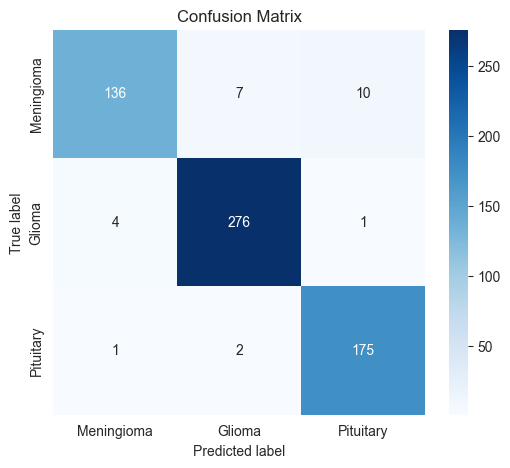

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.9645    0.8889    0.9252       153
      Glioma     0.9684    0.9822    0.9753       281
   Pituitary     0.9409    0.9831    0.9615       178

    accuracy                         0.9592       612
   macro avg     0.9579    0.9514    0.9540       612
weighted avg     0.9594    0.9592    0.9587       612



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

new_model_3.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(new_model_3.device)
        masks = masks.to(new_model_3.device)
        labels = labels.to(new_model_3.device)

        seg_logits, class_logits = new_model_3(images)  # get both logits

        preds = torch.argmax(class_logits, 1)  # for cls needed now

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))

# Save model

In [10]:
trainer.save_checkpoint("checkpoints/Model_G_Modified_Classification_Informed_Segmentation.ckpt")